# Plot the Rotor Plane averages

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import postproamrwindsample_xarray as ppsamplexr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
def computeDSfunc(dsvec, tagname, func):
    for turb, ds in dsvec.items():
        dsvec[turb][tagname] = func(ds)

def avgDSfield(dsvec, turblist, excludekeys=['group', 'times']):
    avgds = {}
    # Get a list of all keys 
    allkeys = [k for k, g in dsvec[turblist[0]].items()]
    #print(allkeys)
    # Loop over all turbines
    for turb in turblist:
        #print(turb)
        ds = dsvec[turb]
        for key, dat in ds.items():
            if key in excludekeys: continue
            if key in avgds:
                avgds[key] = avgds[key] + dat
            else:
                avgds[key] = dat+0.0
    # normalize averages
    for key in allkeys:
        if key in excludekeys: continue
        avgds[key] = avgds[key]/float(len(turblist))
    #print(float(len(turblist)))
    return avgds

In [3]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[1])*dx
    yvec=np.arange(hhshape[0])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm, ym
    #return xm.transpose(), ym.transpose()

def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

In [4]:
summitcsv    = '../../UnstableABL_farmrun_turbines.csv'

iplane       = 0
zhh          = 90
rotorD       = 127

In [5]:
savefigs = True
figdir   = '../JRSE_figs'

In [6]:
allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))

In [7]:
# Load the updraft/downdraft lists
with open('updraftturbines.txt') as f:
    updraftturbs = f.read().splitlines()

with open('downdraftturbines.txt') as f:
    downdraftturbs = f.read().splitlines()

In [8]:
# Load the rotor plane averages
picklefile='AllKP_RPplanes_wturb.pkl'
pfile          = open(picklefile, 'rb')
allds_wturb    = pickle.load(pfile)
pfile.close()

In [9]:
# Load the rotor plane averages
picklefile='AllKP_RPplanes_noturb.pkl'
pfile          = open(picklefile, 'rb')
allds_noturb    = pickle.load(pfile)
pfile.close()

In [10]:
#for k, g in allds_wturb.items(): print(k)

In [11]:
# compute TKE
calctke = lambda ds: 0.5*(ds['velocityx_std']**2 + ds['velocityy_std']**2 + ds['velocityz_std']**2)
#computeDSfunc(allds_noturb, 'TKE', calctke)
computeDSfunc(allds_wturb, 'TKE', calctke)

In [12]:
avgup_wturb    = avgDSfield(allds_wturb,  updraftturbs[:])
avgdown_wturb  = avgDSfield(allds_wturb, downdraftturbs[:])

In [13]:
avgup_noturb    = avgDSfield(allds_noturb,  updraftturbs[:])
avgdown_noturb  = avgDSfield(allds_noturb, downdraftturbs[:])

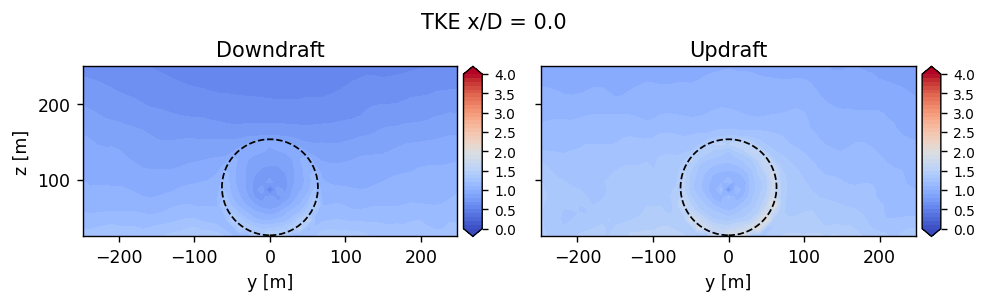

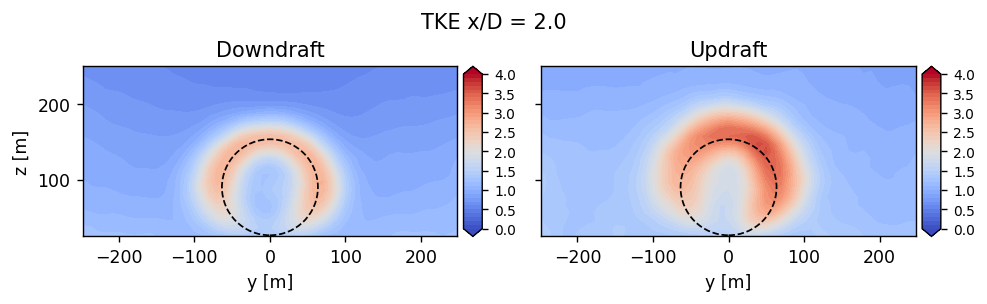

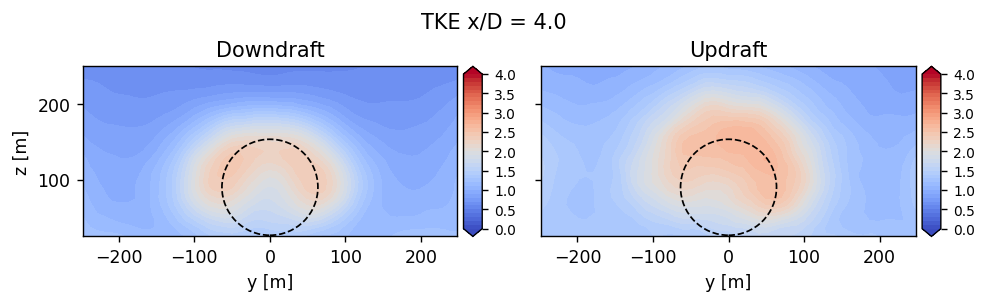

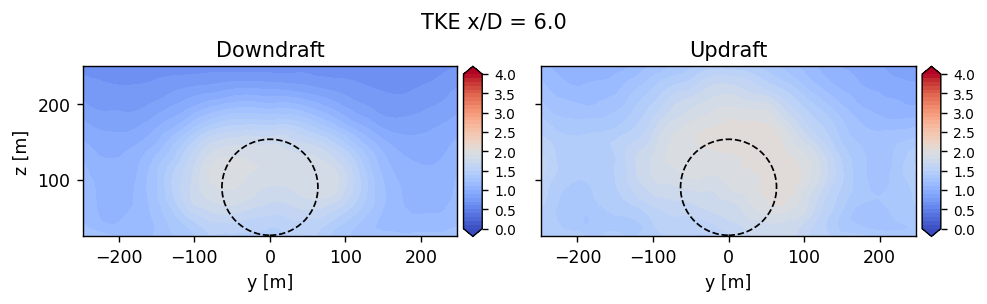

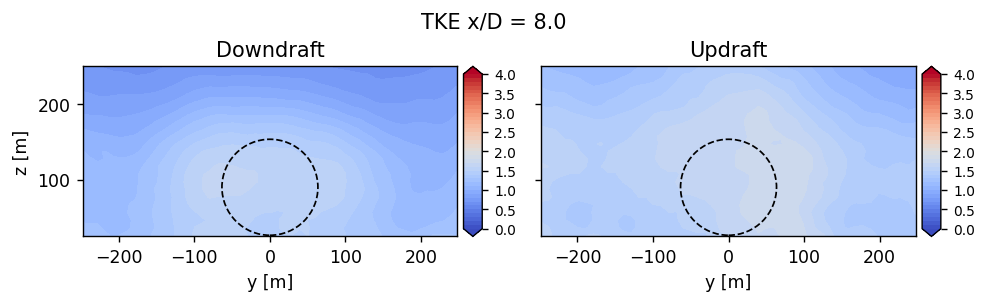

In [17]:
xm = avgup_wturb['x'][0,:,:]-np.min(avgup_wturb['x'][0,:,:])
zm = avgup_wturb['z'][0,:,:]
L = np.max(xm)
xm -= 0.5*L
fontsize=8
clevels=np.linspace(0,4,41)

ilevels = [4,5,6, 7, 8]
for i in ilevels:
    fig, axs = plt.subplots(1,2, figsize=(8,2.5), dpi=125, sharey=True)
    # Downdraft
    c = axs[0].contourf(xm, zm, avgdown_wturb['TKE'][i,:,:], levels=clevels, extend='both', cmap='coolwarm')
    makecbarax(axs[0], c, fontsize, size='5%')
    circle0 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    axs[0].add_patch(circle0)
    axs[0].set_title('Downdraft')
    # Updraft
    c = axs[1].contourf(xm, zm, avgup_wturb['TKE'][i,:,:], levels=clevels, extend='both', cmap='coolwarm')
    makecbarax(axs[1], c, fontsize, size='5%')
    circle1 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    axs[1].add_patch(circle1)
    axs[1].set_title('Updraft')

    for ax in axs:
        ax.set_xlabel('y [m]')
        #ax.set_xlim([-125, 125])
        ax.set_ylim([25, 250])
        ax.set_aspect('equal')
    xlocation = (i-4)*2
    fig.suptitle('TKE x/D = %0.1f'%(xlocation), y=0.9,)

    axs[0].set_ylabel('z [m]')
    plt.tight_layout()

    if savefigs:
        plt.savefig(figdir+'/rotorplane_TKE_%iD.png'%xlocation)
        plt.savefig(figdir+'/rotorplane_TKE_%iD.pdf'%xlocation)

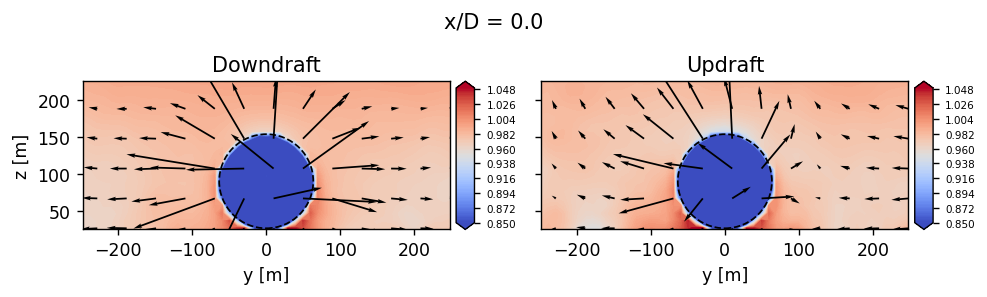

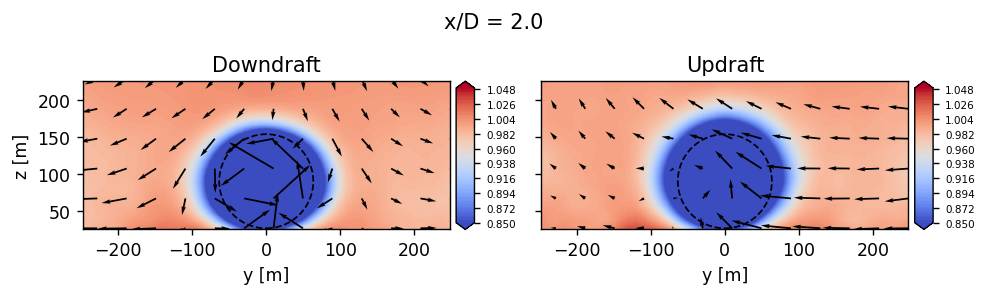

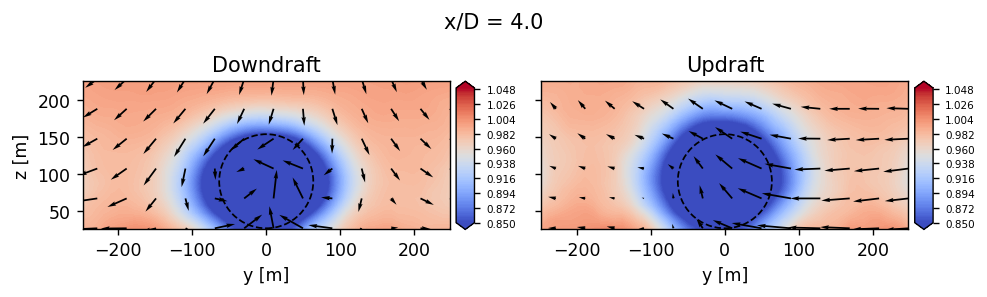

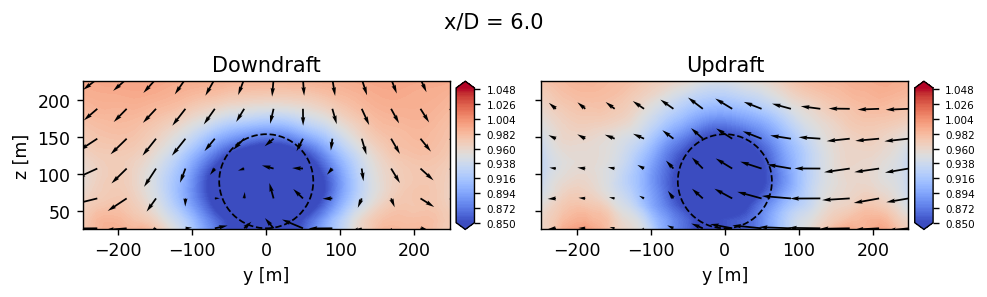

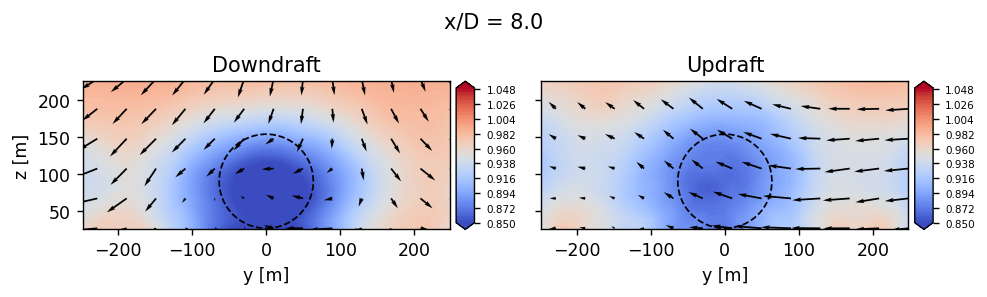

In [18]:
xm = avgup_wturb['x'][0,:,:]-np.min(avgup_wturb['x'][0,:,:])
zm = avgup_wturb['z'][0,:,:]
L = np.max(xm)
xm -= 0.5*L
fontsize=6
#clevels=np.linspace(6,10,121)
clevels=np.linspace(0.85, 1.05, 101)

ilevels = [4,5,6, 7, 8]
for i in ilevels:
    xlocation = (i-4)*2
    theta=5
    nx, ny = np.cos(theta*np.pi/180.0), np.sin(theta*np.pi/180.0)

    # Set up the quiver plots
    s1 = 4
    s2 = 4
    qx = xm[::s1,::s2]
    qz = zm[::s1,::s2]
    qu = avgup_wturb['velocityx_avg'][i,::s1,::s2]
    qv = avgup_wturb['velocityy_avg'][i,::s1,::s2]
    qw_up = avgup_wturb['velocityz_avg'][i,::s1,::s2]
    qu_up = qu-np.mean(qu)
    qu_up = qu*nx + qv*ny

    qu = avgdown_wturb['velocityx_avg'][i,::s1,::s2]
    qv = avgdown_wturb['velocityy_avg'][i,::s1,::s2]
    qw_down = avgdown_wturb['velocityz_avg'][i,::s1,::s2]
    qu_down = qu-np.mean(qu)
    qu_down = qu*nx + qv*ny

    Uhoriz_up  = np.sqrt(avgup_wturb['velocityx_avg'][i,:,:]**2 + avgup_wturb['velocityy_avg'][i,:,:]**2)
    Uhoriz_down = np.sqrt(avgdown_wturb['velocityx_avg'][i,:,:]**2 + avgdown_wturb['velocityy_avg'][i,:,:]**2)

    Uhoriz_up_pre  = np.sqrt(avgup_noturb['velocityx_avg'][i,:,:]**2 + avgup_noturb['velocityy_avg'][i,:,:]**2)
    Uhoriz_down_pre = np.sqrt(avgdown_noturb['velocityx_avg'][i,:,:]**2 + avgdown_noturb['velocityy_avg'][i,:,:]**2)

    fig, axs = plt.subplots(1,2, figsize=(8,2.5), dpi=125, sharey=True)
    # Downdraft
    c = axs[0].contourf(xm, zm, Uhoriz_down/Uhoriz_down_pre, levels=clevels, extend='both', cmap='coolwarm')
    axs[0].quiver(qx, qz, qu_down, qw_down, headwidth=2.5)
    makecbarax(axs[0], c, fontsize, size='5%')
    circle0 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    axs[0].add_patch(circle0)
    axs[0].set_title('Downdraft')
    
    # Updraft
    c = axs[1].contourf(xm, zm, Uhoriz_up/Uhoriz_up_pre, levels=clevels, extend='both', cmap='coolwarm')
    makecbarax(axs[1], c, fontsize, size='5%')
    axs[1].quiver(qx, qz, qu_up, qw_up, headwidth=2.5)
    circle1 = plt.Circle((0, 90), rotorD/2, color='k', fill=False, ls='--')
    axs[1].add_patch(circle1)
    axs[1].set_title('Updraft')
    for ax in axs:
        ax.set_xlabel('y [m]')
        #ax.set_xlim([-130, 130])
        ax.set_ylim([25, 225])
        ax.set_aspect('equal')
    fig.suptitle('x/D = %0.1f'%(xlocation), y=0.9,)
    axs[0].set_ylabel('z [m]')
    plt.tight_layout()

    if savefigs:
        plt.savefig(figdir+'/rotorplane_Uh_%iD.png'%xlocation)
        plt.savefig(figdir+'/rotorplane_Uh_%iD.pdf'%xlocation)